In [25]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.linalg

In [82]:
lam = 120
mu = 60

E = np.array([
    [lam + 2 * mu, lam, 0],
    [lam, lam + 2 * mu, 0],
    [0, 0, mu]
])

In [83]:
B = np.array([
    [-1, 0, 1, 0, 0, 0],
    [0, -1, 0, 0, 0, 1],
    [-1, -1, 0, 1, 1, 0]
])

In [84]:
k = np.transpose(B) @ E @ B
k

array([[ 300,  180, -240,  -60,  -60, -120],
       [ 180,  300, -120,  -60,  -60, -240],
       [-240, -120,  240,    0,    0,  120],
       [ -60,  -60,    0,   60,   60,    0],
       [ -60,  -60,    0,   60,   60,    0],
       [-120, -240,  120,    0,    0,  240]])

In [85]:
np.linalg.matrix_rank(k)

3

In [86]:
Field = np.array([
    [True, False, False],
    [True, True, True],
    [True, False, False]
])

In [98]:
counter = 0
positionsIn = []

edgesOnRectangle = np.array([(0, 0), (1, 0), (1, 1), (0, 1)])

for x in range(Field.shape[0]):
    for y in range(Field.shape[1]):
        if Field[x, y]:
            for edge in edgesOnRectangle:
                pos = edge + (x, y)
                pos = (pos[0], pos[1])
                if pos not in positionsIn:
                    counter += 1
                    positionsIn.append(pos)


# Effective method for calculating K
KGlob = np.zeros((2 * counter, 2 * counter))

for x in range(Field.shape[0]):
    for y in range(Field.shape[1]):
        if Field[x, y]:
            evenI = lambda pos: positionsIn.index((x + pos[0], y + pos[1])) * 2
            oddI = lambda pos: positionsIn.index((x + pos[0], y + pos[1])) * 2 + 1

            targetIndices = [evenI((0, 0)), oddI((0, 0)), evenI((1, 0)), oddI((1, 0)), evenI((0, 1)), oddI((0, 1))]

            for i in range(k.shape[0]):
                for j in range(k.shape[1]):
                    KGlob[targetIndices[i], targetIndices[j]] += k[i, j]

            targetIndices = [evenI((1, 1)), oddI((1, 1)), evenI((0, 1)), oddI((0, 1)), evenI((1, 0)), oddI((1, 0))]

            for i in range(k.shape[0]):
                for j in range(k.shape[1]):
                    KGlob[targetIndices[i], targetIndices[j]] += k[i, j]
KGlob = np.delete(np.delete(KGlob, 22, 0), 22, 1)
KGlob = np.delete(np.delete(KGlob, 21, 0), 21, 1)
KGlob = np.delete(np.delete(KGlob, 20, 0), 20, 1)
KGlobBack = KGlob
KGlob.shape

(21, 21)

In [99]:
np.linalg.matrix_rank(KGlob)

21

In [106]:
f = np.zeros((KGlob.shape[0], 1))
f[18] = 10

In [107]:
# https://en.wikipedia.org/wiki/Conjugate_gradient_method

x_k = np.zeros((KGlob.shape[1], 1))
r_k = f - KGlob @ x_k
p_k = r_k
for k in range(50):
    alpha_k = r_k.transpose() @ r_k / (p_k.transpose() @ KGlob @ p_k)
    x_k1 = x_k + alpha_k * p_k
    r_k1 = r_k - alpha_k * KGlob @ p_k
    if np.linalg.norm(r_k1) < 1e-20:
        break
    beta_k = r_k1.transpose() @ r_k1 / (r_k.transpose() @ r_k)
    p_k1 = r_k1 + beta_k * p_k
    x_k = x_k1
    r_k = r_k1
    p_k = p_k1
# x_k1 = L @ x_k1
print(k, x_k1,np.linalg.norm(KGlob @ x_k1 - f))

47 [[0.02300907]
 [1.43151567]
 [0.02300284]
 [0.91935377]
 [0.5353142 ]
 [0.91916072]
 [0.53520833]
 [1.43150944]
 [0.02251086]
 [0.40939643]
 [0.53789152]
 [0.40142604]
 [1.05359761]
 [0.40153203]
 [1.05355602]
 [0.91774527]
 [1.56977865]
 [0.40153337]
 [1.56977731]
 [0.91772246]
 [0.29544182]] 3.953581353710989e-13


In [22]:
a = np.copy(KGlob)
for k in range(KGlob.shape[0]):
    a[k, k] = np.sqrt(a[k, k])
    for i in range(k + 1, KGlob.shape[0]):
        a[i, k] = a[i, k] / a[k, k]
    for j in range(k + 1, KGlob.shape[0]):
        a[i, j] = a[i, j] - a[i, k] * a[j, k]
for i in range(KGlob.shape[0]):
    for j in range(i + 1, KGlob.shape[0]):
        a[i, j] = 0
L = a
M = L @ L

In [23]:
x = np.linalg.solve(np.linalg.inv(M) @ KGlob, np.linalg.inv(M) @ f)
np.linalg.norm(KGlob @ x - f)

2.975441216166861e-13

In [30]:
(P, L, U) = scipy.linalg.lu(KGlob)
KGlobEstimate = P @ L @ np.diag(np.diag(U)) @ L.transpose()
M = KGlobEstimate
# M

In [34]:
M = np.diag(np.diag(KGlobEstimate))

In [35]:
np.linalg.cond(KGlob), np.linalg.cond(np.linalg.inv(M) @ KGlob)

(1952.2872913410556, 1940.9019431110287)

In [36]:
# https://en.wikipedia.org/wiki/Conjugate_gradient_method

L = np.eye(KGlob.shape[0])
KGlob = KGlobBack
# KGlob = np.eye(KGlob.shape[0])

L = np.linalg.inv(M)
x_k = np.zeros((KGlob.shape[1], 1))
r_k = f - KGlob @ x_k
z_k = L @ r_k
p_k = z_k
for k in range(100000):
    alpha_k = r_k.transpose() @ z_k / (p_k.transpose() @ KGlob @ p_k)
    x_k1 = x_k + alpha_k * p_k
    r_k1 = r_k - alpha_k * KGlob @ p_k
    if np.linalg.norm(r_k1) < 1e-20:
        break
    z_k1 = L @ r_k1
    beta_k = r_k1.transpose() @ z_k1 / (r_k.transpose() @ z_k)
    p_k1 = z_k1 + beta_k * p_k
    x_k = x_k1
    r_k = r_k1
    p_k = p_k1
    z_k = z_k1
# x_k1 = L @ x_k1
print(k, np.linalg.norm(KGlob @ x_k1 - f))
eps = x_k1

46 3.502379571250427e-13


In [37]:
from scipy.sparse.linalg import cg
x, info = cg(KGlob, f)
np.linalg.norm(KGlob @ x - f), info

(632.4555347515626, 0)

In [38]:
np.linalg.norm(KGlob @ (eps) - f)
epsBack = eps
fBack = f

In [40]:
epsBack.shape, eps.shape

((21, 1), (21, 1))

In [41]:
eps, epsBack

(array([[ 3.56909885e-04],
        [-8.20892737e-03],
        [ 2.85527908e-03],
        [ 6.06746805e-03],
        [ 3.56909885e-04],
        [ 2.85527908e-02],
        [-1.42763954e-01],
        [ 4.56793404e-01],
        [-2.90473398e-01],
        [ 1.09673833e-01],
        [-6.00069850e-01],
        [ 4.50718599e-01],
        [-6.02452881e-01],
        [ 1.10982577e-01],
        [-9.41583531e-01],
        [ 4.50620598e-01],
        [-9.41621987e-01],
        [ 1.11003666e-01],
        [-1.28122899e+00],
        [ 4.50619358e-01],
        [-1.28123024e+00]]), array([[ 3.56909885e-04],
        [-8.20892737e-03],
        [ 2.85527908e-03],
        [ 6.06746805e-03],
        [ 3.56909885e-04],
        [ 2.85527908e-02],
        [-1.42763954e-01],
        [ 4.56793404e-01],
        [-2.90473398e-01],
        [ 1.09673833e-01],
        [-6.00069850e-01],
        [ 4.50718599e-01],
        [-6.02452881e-01],
        [ 1.10982577e-01],
        [-9.41583531e-01],
        [ 4.50620598e-01],


((24, 1), (24, 1), 12)

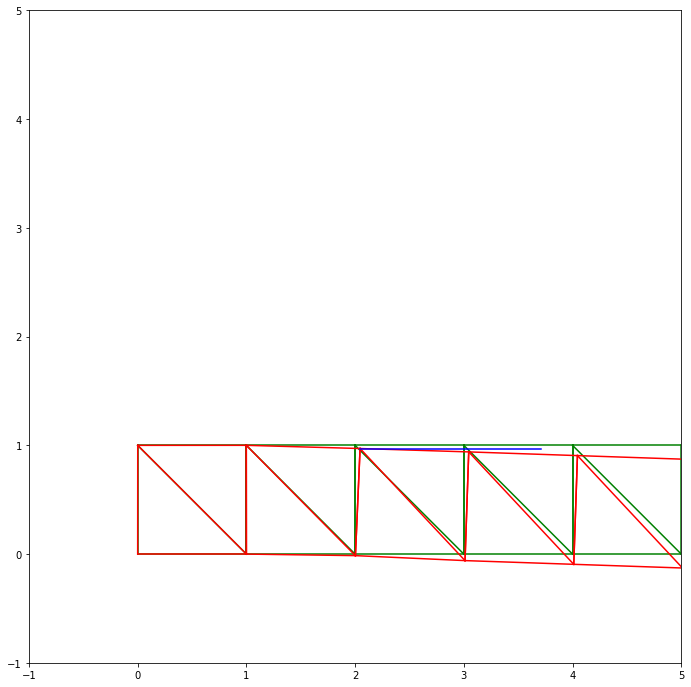

In [42]:
eps = np.concatenate((np.array([[0], [0]] + [epsBack[0]] + [[0]]), epsBack[1:]), axis=0)
f = np.concatenate((np.array([[0], [0]] + [fBack[0]] + [[0]]), fBack[1:]), axis=0)

positions = [
    (0, 0), (1, 0), (2, 0), (3, 0), (4, 0),
    (0, 1), (1, 1), (2, 1), (3, 1), (4, 1),
]

positions = positionsIn

squares = [
    [0, 1, 6, 5, 0],
    [1, 2, 7, 6, 1],
    [2, 3, 8, 7, 2],
    [3, 4, 9, 8, 3]
]
squares = []
for x in range(Field.shape[0]):
    for y in range(Field.shape[1]):
        if Field[x, y]:
            row = []
            for edge in edgesOnRectangle:
                pos = edge + (x, y)
                pos = (pos[0], pos[1])
                i = positionsIn.index(pos)
                row.append(i)
            row.append(row[0])
            squares.append(row)
scale = 0.1
plt.figure(figsize=(12, 12))
for square in squares:
    for i in range(4):
        startI = square[i]
        endI = square[i + 1]
        plt.plot(
            [positions[startI][0], positions[endI][0]],
            [positions[startI][1], positions[endI][1]],
            color='g'
            )
    startI = square[1]
    endI = square[3]
    plt.plot(
        [positions[startI][0], positions[endI][0]],
        [positions[startI][1], positions[endI][1]],
            color='g'
        )
for square in squares:
    for i in range(4):
        startI = square[i]
        endI = square[i + 1]
        plt.plot(
            [positions[startI][0] + eps[2 * startI, 0]*scale, positions[endI][0] + eps[2 * endI, 0]*scale],
            [positions[startI][1] + eps[2 * startI + 1, 0]*scale, positions[endI][1] + eps[2 * endI + 1, 0]*scale],
            color='r'
            )
    startI = square[1]
    endI = square[3]
    plt.plot(
        [positions[startI][0] + eps[2 * startI, 0]*scale, positions[endI][0] + eps[2 * endI, 0]*scale],
        [positions[startI][1] + eps[2 * startI + 1, 0]*scale, positions[endI][1] + eps[2 * endI + 1, 0]*scale],
            color='r'
        )
plt.xlim([-1, 5])
plt.ylim([-1, 5])
plt.gca().set_aspect(1)

for i in range(len(positions)):
    pos = np.array(positions[i]) + [eps[2 * i, 0]*scale, eps[2 * i + 1, 0]*scale]
    plt.plot([pos[0], pos[0] + f[2 * i, 0] / 60.], [pos[1], pos[1]], color='b')
    plt.plot([pos[0], pos[0]], [pos[1], pos[1] + f[2 * i + 1, 0] / 60.], color='b')
    i += 1
f.shape, eps.shape, len(positions)

In [50]:
eps.shape

(24, 1)

In [55]:
q = eps # Naming error

Aq = []
for x in range(Field.shape[0]):
    for y in range(Field.shape[1]):
        if Field[x, y]:
            evenI = lambda pos: positionsIn.index((x + pos[0], y + pos[1])) * 2
            oddI = lambda pos: positionsIn.index((x + pos[0], y + pos[1])) * 2 + 1

            targetIndices = [evenI((0, 0)), oddI((0, 0)), evenI((1, 0)), oddI((1, 0)), evenI((0, 1)), oddI((0, 1))]
            qLocal = np.array([q[i] for i in targetIndices])
            Aq.append(qLocal)

            targetIndices = [evenI((1, 1)), oddI((1, 1)), evenI((0, 1)), oddI((0, 1)), evenI((1, 0)), oddI((1, 0))]
            qLocal = np.array([q[i] for i in targetIndices])
            Aq.append(qLocal)
Aq = np.array(Aq)
print(Aq.shape)

sigma = E[None, :] @ B[None, :] @ Aq
sigma.shape

(10, 6, 1)


(10, 3, 1)

In [56]:
sigma

array([[[ 1.28487559e-01],
        [ 1.28487559e-01],
        [ 3.64048083e-01]],

       [[ 3.08370141e+00],
        [ 1.02790047e+00],
        [ 3.64048083e-01]],

       [[ 7.10964492e+00],
        [ 4.06877269e+00],
        [-9.07978749e+00]],

       [[-9.38754264e+01],
        [-2.03500134e+01],
        [-8.09471620e+00]],

       [[ 1.74391695e+00],
        [-2.57157413e+01],
        [-1.74391695e+00]],

       [[ 1.74391695e+00],
        [ 1.30090399e+00],
        [-1.74391695e+00]],

       [[ 2.81348958e-02],
        [-4.14878066e-01],
        [-2.81348958e-02]],

       [[ 2.81348958e-02],
        [ 2.09895254e-02],
        [-2.81348958e-02]],

       [[ 4.46585647e-04],
        [-6.69878471e-03],
        [-4.46585647e-04]],

       [[ 4.46585647e-04],
        [ 4.46585647e-04],
        [-4.46585647e-04]]])

In [778]:
sigma_v = np.sqrt(sigma[:, 0] ** 2 + sigma[:, 1] ** 2 + sigma[:, 0] * sigma[:, 1] + 3 * (sigma[:, 2] ** 2))
sigma_v

array([ 13.68259341,  25.15112011,  35.47704548,  70.00179576,
        47.70348886,  33.03365163, 104.27129504,  18.52833011,
        16.90220385,  13.02826588])

In [73]:
K = np.array([
[   3e+02, 1.8e+02,-2.4e+02,     -60,       0,       0,     -60,-1.2e+02,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0],
[ 1.8e+02,   3e+02,-1.2e+02,     -60,       0,       0,     -60,-2.4e+02,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0],
[-2.4e+02,-1.2e+02,   6e+02, 1.8e+02,-1.2e+02,-1.8e+02,       0, 1.8e+02,       0,       0,       0,       0,-2.4e+02,     -60,       0,       0,       0,       0,       0,       0,       0],
[     -60,     -60, 1.8e+02,   6e+02,-1.8e+02,-4.8e+02, 1.8e+02,       0,       0,       0,       0,       0,-1.2e+02,     -60,       0,       0,       0,       0,       0,       0,       0],
[       0,       0,-1.2e+02,-1.8e+02,   9e+02, 1.8e+02,-4.8e+02,-1.8e+02,     -60,     -60,       0, 1.8e+02,       0, 1.8e+02,-2.4e+02,-1.2e+02,       0,       0,       0,       0,       0],
[       0,       0,-1.8e+02,-4.8e+02, 1.8e+02,   9e+02,-1.8e+02,-1.2e+02,-1.2e+02,-2.4e+02, 1.8e+02,       0, 1.8e+02,       0,     -60,     -60,       0,       0,       0,       0,       0],
[     -60,     -60,       0, 1.8e+02,-4.8e+02,-1.8e+02,   6e+02, 1.8e+02,       0,       0,     -60,-1.2e+02,       0,       0,       0,       0,       0,       0,       0,       0,       0],
[-1.2e+02,-2.4e+02, 1.8e+02,       0,-1.8e+02,-1.2e+02, 1.8e+02,   6e+02,       0,       0,     -60,-2.4e+02,       0,       0,       0,       0,       0,       0,       0,       0,       0],
[       0,       0,       0,       0,     -60,-1.2e+02,       0,       0,   3e+02, 1.8e+02,-2.4e+02,     -60,       0,       0,       0,       0,       0,       0,       0,       0,       0],
[       0,       0,       0,       0,     -60,-2.4e+02,       0,       0, 1.8e+02,   3e+02,-1.2e+02,     -60,       0,       0,       0,       0,       0,       0,       0,       0,       0],
[       0,       0,       0,       0,       0, 1.8e+02,     -60,     -60,-2.4e+02,-1.2e+02,   3e+02,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0],
[       0,       0,       0,       0, 1.8e+02,       0,-1.2e+02,-2.4e+02,     -60,     -60,       0,   3e+02,       0,       0,       0,       0,       0,       0,       0,       0,       0],
[       0,       0,-2.4e+02,-1.2e+02,       0, 1.8e+02,       0,       0,       0,       0,       0,       0,   9e+02, 1.8e+02,-1.2e+02,-1.8e+02,     -60,     -60,       0, 1.8e+02,-4.8e+02],
[       0,       0,     -60,     -60, 1.8e+02,       0,       0,       0,       0,       0,       0,       0, 1.8e+02,   9e+02,-1.8e+02,-4.8e+02,-1.2e+02,-2.4e+02, 1.8e+02,       0,-1.8e+02],
[       0,       0,       0,       0,-2.4e+02,     -60,       0,       0,       0,       0,       0,       0,-1.2e+02,-1.8e+02,   6e+02, 1.8e+02,       0,       0,       0,       0,       0],
[       0,       0,       0,       0,-1.2e+02,     -60,       0,       0,       0,       0,       0,       0,-1.8e+02,-4.8e+02, 1.8e+02,   6e+02,       0,       0,       0,       0, 1.8e+02],
[       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,     -60,-1.2e+02,       0,       0,   3e+02, 1.8e+02,-2.4e+02,     -60,       0],
[       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,     -60,-2.4e+02,       0,       0, 1.8e+02,   3e+02,-1.2e+02,     -60,       0],
[       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0, 1.8e+02,       0,       0,-2.4e+02,-1.2e+02,   3e+02,       0,     -60],
[       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0, 1.8e+02,       0,       0,       0,     -60,     -60,       0,   3e+02,-1.2e+02],
[       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,       0,-4.8e+02,-1.8e+02,       0, 1.8e+02,       0,       0,     -60,-1.2e+02,   6e+02],
])

In [77]:
np.linalg.matrix_rank(K)

20

In [78]:
K.shape

(21, 21)